<a href="https://colab.research.google.com/github/helissonomc/Gallery-Image/blob/master/Arranjo_autoencoder_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
#from plotcm import plot_confusion_matrix

import pdb
import sys
import time

In [2]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)

1.8.1+cu101
True
10.1


# Função fit

In [3]:
torch.set_grad_enabled(True)

In [84]:
def fit_autoencoder(network,train_set,epochs=1, batch_size=1, lr=0.001):
  criterion = nn.BCELoss()

  optimizer = optim.Adam(network.parameters(), lr=lr)
  total_loss = 0
  total_correct = 0

  images = train_set/255
  images = images.cuda()
  #plt.imshow(images.squeeze())
  preds = network(images) # Pass Batch
  #Quando estiver na etapa de pegar a imagem de saida do BN esses passos nao são necessarios serem executados
  if(not network.bn_out):
    loss = criterion(preds, images.detach()) # Calculate Loss

    optimizer.zero_grad()

    loss.backward(retain_graph=True) # Calculate Gradients

    total_loss += loss.item()
  #Quando estiver na etapa de apenas encontrar o gradiente para o modelo, não se deve fazer a atualização dos pesos
  if(network.allowTrain):
    optimizer.step() # Update Weights

  
  
  #total_correct += get_num_correct(preds, images)
  # if(network.allowTrain and not network.bn_out ):
    # print(
    #   #"epoch", epoch, 
    #   #"total_correct:", total_correct, 
    #   "loss:", total_loss
    # )

  #Quando estiver na etapa de pegar a imagem de saida do BN, esta função retorn a imagem
  
  if(not network.bn_out):
    print(torch.sum(network.encoder[2].weight.grad))
    print(loss.item())
    return network.encoder[2].weight.grad
  else:
    return preds

In [5]:
def fit_output(network,train_set, target, epochs=1, batch_size=1, lr=0.001):
  optimizer = optim.Adam(network.parameters(), lr=lr)
  images, labels = train_set, target
  images, labels = images.cuda(), labels.cuda()
  total_loss = 0
  preds = network(images) # Pass Batch
  loss = F.cross_entropy(preds, labels) # Calculate Loss
  optimizer.zero_grad()
  loss.backward() # Calculate Gradients
  optimizer.step() # Update Weights

  total_loss += loss.item()
  # print(
  #       "loss:", total_loss
  #   )

# Modelo

In [70]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.allowTrain = True
        self.bn_out = False
        # Encoder
        self.encoder = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3),
          nn.ReLU(inplace=False),
          nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3),
          nn.ReLU(inplace=False),
        )
        # Decoder
        self.decoder = nn.Sequential(
          nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=3),
          nn.ReLU(inplace=False),
          nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=3),
          nn.ReLU(inplace=False),
        )

    def forward(self, t):
      # flatten
      #t = t.view(t.size(0), -1)
      # Encoder
      t = t.cuda()
      t = self.encoder(t)
      print(t)
      #Se tiver na etapa de apenas pegar a imagem do BN, ela ja é retornada aqui
      if(self.bn_out):
        return t
      #Decoder
      t = self.decoder(t)
      return t

In [7]:
class OutPutNetwork(nn.Module):
    def __init__(self):
        super(OutPutNetwork, self).__init__()
        self.output_layer = nn.Linear(in_features=20*20, out_features=10)

    def forward(self, t):
      #Flat
      t = t.cuda()
      t = t.view(t.size(0), -1)

      t = self.output_layer(t)
      t = F.softmax(t, dim=1)
      return t

# AutoencoderNet

In [8]:
class AutoencoderNet:
    def __init__(self, **kwargs):
      self.modelsBuilt = self.net(**kwargs)

    #Função que monta a rede de AutoENcoders
    def net(self, **kwargs):
      listAE = [[] for _ in range(kwargs['numberLevel'])]
      bottleneck = None
      for i in range(kwargs['numberLevel']):
          
        for j in range(3**(i+1)):
            listAE[i].append(Network().cuda())
          
      return listAE

    #Adiciona a ultima camada (Camada densa)
    def add_output_layer(self):
      self.modelsBuilt.append([])
      for i in range(len(self.modelsBuilt[-2])):
        self.modelsBuilt[-1].append(OutPutNetwork().cuda())

    #Passo que realiza o treinamento e escolha do caminho a ser seguido pela imagem
    def train_step(self, train_set,target):
      for i in range(len(self.modelsBuilt)):
        if(i == 0):
          choosenIndex = self.choose_AE(self.modelsBuilt[i], train_set).item()
          #treinando modelo escolhido de fato
          fit_autoencoder(self.modelsBuilt[i][choosenIndex], train_set)
          
          bn_image = train_set
        else:
          #Pega Imagem do BN do Modelo Vencedor na interação anterior
          self.modelsBuilt[i-1][choosenIndex].bn_out = True
          self.modelsBuilt[i-1][choosenIndex].allowTrain = False
          torch.set_grad_enabled(False)
          bn_image = fit_autoencoder(self.modelsBuilt[i-1][choosenIndex], bn_image)
          torch.set_grad_enabled(True)
          self.modelsBuilt[i-1][choosenIndex].bn_out = False
          self.modelsBuilt[i-1][choosenIndex].allowTrain = True

          if(i != len(self.modelsBuilt)-1):
            # Escolhe o melhor modelo baseado no modelos "filhos" da interção anterior
            choosenIndex = choosenIndex*3+self.choose_AE(self.modelsBuilt[i][choosenIndex*3:(choosenIndex*3)+3], bn_image).item()
            fit_autoencoder(self.modelsBuilt[i][choosenIndex], bn_image)
          else:
            # Entra aqui quando chegar na ultima camada (camada densa)
            # print(bn_image.shape)
            fit_output(self.modelsBuilt[i][choosenIndex], bn_image, target)

    # Função responsavel por percorrer os dados de treinamento e passar estes dados para o treino_step
    def fit_network(self, train_loader, epochs=1):
      for i in range(epochs):
        print('\n======================================================================')
        print('EPOCH >> '+str(i))
        print('_________________________________________________________________________')
        for j, batch in enumerate(train_loader):
          sys.stdout.write("\r |Imagens "+str(j+1)+" de "+str(len(train_loader)) + "|")
          sys.stdout.flush()
          self.train_step(batch[0],batch[1])
          


    # Função que faz a predição
    def predict_step(self, train_set):
      for i in range(len(self.modelsBuilt)):
        if(i == 0):
          choosenIndex = self.choose_AE(self.modelsBuilt[i], train_set).item()        
          bn_image = train_set
        else:
          
          #Pega Imagem do BN do Modelo Vencedor na interação anterior
          self.modelsBuilt[i-1][choosenIndex].bn_out = True
          self.modelsBuilt[i-1][choosenIndex].allowTrain = False
          torch.set_grad_enabled(False)
          bn_image = fit_autoencoder(self.modelsBuilt[i-1][choosenIndex], bn_image)
          torch.set_grad_enabled(True)
          self.modelsBuilt[i-1][choosenIndex].bn_out = False
          self.modelsBuilt[i-1][choosenIndex].allowTrain = True

          if(i != len(self.modelsBuilt)-1):
            
            choosenIndex = choosenIndex*3+self.choose_AE(self.modelsBuilt[i][choosenIndex*3:(choosenIndex*3)+3], bn_image).item()
       
          else:
            return self.modelsBuilt[i][choosenIndex](bn_image)

    # Função que faz o looping nos dados e passa os valores para a função predict_step
    def predict(self, loader):
      all_preds = torch.tensor([]).cuda()
      for j, batch in enumerate(loader):
          sys.stdout.write("\r |Imagens "+str(j+1)+" de "+str(len(train_loader)) + "|")
          sys.stdout.flush()
          images, labels = batch

          preds = self.predict_step(images)
          all_preds = torch.cat(
              (all_preds, preds)
              ,dim=0
          )
      return all_preds

    # Recebe as opções de autoencoder e escolhe o que tem a menor soma absoluta do gradiente
    def choose_AE(self, options, train_set):
      history = []
      image = train_set
      for modelBuilt in options:
        #Setando como falso para apenas pegar os valores do gradiente e não atualizar pesos
        modelBuilt.allowTrain = False
        history.append(
            torch.sum(torch.abs(fit_autoencoder(modelBuilt, image)))
        )
        modelBuilt.allowTrain = True
      return torch.argmin(torch.tensor(history))
      
      # modelBuilt.allowTrain = True 
        #print(get_min_grad(history))
        #return get_min_grad(history)

# Main

In [71]:
nae = AutoencoderNet(numberLevel=2)

In [72]:
nae.add_output_layer()

In [73]:
train_set = torchvision.datasets.FashionMNIST(
    root='./data'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

In [74]:
train_loader = torch.utils.data.DataLoader(
      train_set
      ,batch_size=1
      ,shuffle=True
)


In [81]:
nae.fit_network(train_loader, 10)

A saída de streaming foi truncada nas últimas 5000 linhas.
           0.1518, 0.1518, 0.1518, 0.1518],
          [0.1518, 0.1518, 0.1518, 0.1518, 0.1518, 0.1518, 0.1518, 0.1518,
           0.1518, 0.1518, 0.1518, 0.1518, 0.1518, 0.1518, 0.1518, 0.1518,
           0.1518, 0.1518, 0.1518, 0.1518],
          [0.1518, 0.1518, 0.1518, 0.1518, 0.1518, 0.1518, 0.1518, 0.1518,
           0.1518, 0.1518, 0.1518, 0.1518, 0.1518, 0.1518, 0.1518, 0.1518,
           0.1518, 0.1518, 0.1518, 0.1518],
          [0.1518, 0.1518, 0.1518, 0.1518, 0.1518, 0.1518, 0.1518, 0.1518,
           0.1518, 0.1518, 0.1518, 0.1518, 0.1518, 0.1518, 0.1518, 0.1518,
           0.1518, 0.1518, 0.1518, 0.1518],
          [0.1518, 0.1518, 0.1518, 0.1518, 0.1518, 0.1518, 0.1518, 0.1518,
           0.1518, 0.1518, 0.1518, 0.1518, 0.1518, 0.1518, 0.1518, 0.1518,
           0.1518, 0.1518, 0.1518, 0.1518],
          [0.1518, 0.1518, 0.1518, 0.1518, 0.1518, 0.1518, 0.1518, 0.1518,
           0.1518, 0.1518, 0.1518, 0.1518, 0.1

KeyboardInterrupt: ignored

In [24]:
test_set = torchvision.datasets.FashionMNIST(
    root='./data'
    ,train=False
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

In [ ]:
test_loader = torch.utils.data.DataLoader(
      test_set
      ,batch_size=1
      ,shuffle=True
)

In [ ]:
pred = nae.predict(test_loader)

In [ ]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels.cuda()).sum().item()

In [ ]:
get_num_correct(pred, test_loader.dataset.targets)

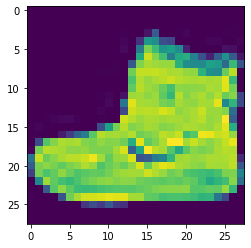

In [58]:
plt.imshow(train_loader.dataset.data[0])

In [61]:
nae.modelsBuilt[0][0]

Network(
  (encoder): Sequential(
    (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
  )
)

In [86]:
a = fit_autoencoder(nae.modelsBuilt[0][0], train_loader.dataset.data[0].unsqueeze(0).unsqueeze(0))

tensor([[[[0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
           0.0100, 0.0109, 0.0080, 0.0160, 0.0173, 0.0000, 0.0055, 0.0116,
           0.0197, 0.0330, 0.0175, 0.0088, 0.0106, 0.0096, 0.0088, 0.0118],
          [0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
           0.0098, 0.0118, 0.0023, 0.0265, 0.0179, 0.0000, 0.0000, 0.0262,
           0.0378, 0.0000, 0.0508, 0.0320, 0.0144, 0.0107, 0.0126, 0.0034],
          [0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
           0.0099, 0.0108, 0.0015, 0.0422, 0.0000, 0.0000, 0.0000, 0.0047,
           0.0630, 0.0162, 0.0000, 0.0306, 0.0293, 0.0413, 0.0101, 0.0000],
          [0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
           0.0110, 0.0086, 0.0182, 0.0432, 0.0081, 0.0000, 0.0000, 0.0013,
           0.0000, 0.0056, 0.0480, 0.0397, 0.0158, 0.0025, 0.0305, 0.0579],
          [0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0103, 0.0097,
           0.0109, 0.

In [52]:
nae.modelsBuilt[1][2].allowTrain

True

In [39]:
train_loader.dataset.data[0].unsqueeze(0).shape

torch.Size([1, 28, 28])

In [29]:
torch.max(train_loader.dataset.data)

tensor(255, dtype=torch.uint8)

In [91]:
len(nae.modelsBuilt[1])

9